In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
from scipy import interpolate
import os
import matplotlib.pyplot as plt
from cosmojo.universe import Cosmo
# from cosmojo.utils import nl_cmb
from cosmojo.utils import *
import sys; sys.path.append('/Users/fbianchini/Research/FlatSpec/')
from Spec2D import  *
from Sims import  *
import numba
from matplotlib.pyplot import cm  
import matplotlib.colors as mcolors
# import matplotlib.cm as cm

arcmin2rad = np.pi / 180. / 60. 
rad2arcmin = 1./arcmin2rad

In [2]:
cosmo = Cosmo()

In [3]:
cmbspec = cosmo.cmb_spectra(5000)

/Users/fbianchini/anaconda2/lib/python2.7/site-packages/CosMojo-0.1.0-py2.7.egg/cosmojo/universe.py:506: RuntimeWarning: divide by zero encountered in divide
  fact = 2.*np.pi/(ls*(ls+1)) * 1.e12 * self.pars.TCMB**2.
/Users/fbianchini/anaconda2/lib/python2.7/site-packages/CosMojo-0.1.0-py2.7.egg/cosmojo/universe.py:514: RuntimeWarning: invalid value encountered in multiply
  cls[:,i] *= fact


In [4]:
def GetLxLyAngle(nx, dx, ny=None, dy=None, shift=False):
    """ 
    Returns a grid with the angle between Fourier mode in the map. 
    If shift=True (default), \ell = 0 is centered in the grid
    ~ Note: already multiplied by 2\pi 
    """
    lx, ly = GetLxLy(nx, dx, ny=ny, dy=dy, shift=shift)
    return np.arctan2(lx, -ly)


In [5]:
def GetNl(cmbspec, noise, beam, lmax=None, nx=2048, dx=0.5, lbins=np.arange(0,5000.,5)):
    if lmax is None:
        lmax = cmbspec.shape[0]-1
        
    nltt = nl_cmb(noise, beam, lmax)
    nlpp = nl_cmb(noise*np.sqrt(2), beam, lmax)
    
    A_E1 = cmbspec[:,1]**2/(cmbspec[:,1]+nlpp)
    A_B1 = 1./(cmbspec[:,2]+nlpp)
    A_E2 = 1./(cmbspec[:,1]+nlpp)
    A_B2 = cmbspec[:,2]**2/(cmbspec[:,2]+nlpp)
    A_E3 = -2.*cmbspec[:,1]/(cmbspec[:,1]+nlpp)
    A_B3 = cmbspec[:,2]/(cmbspec[:,2]+nlpp)
    
    nx = nx*2
#     dx = dx
    L  = GetL(nx,dx,shift=0)

    v_l = np.ones((nx,nx), dtype=np.complex)
    v_l.imag = np.exp(1j*4*GetLxLyAngle(nx, dx, shift=0))
#     v_l_func = lambda l1,l2: return 1., np.exp(1j*4*GetLxLyAngle(nx, dx, shift=0)) 
#     v_l = 
    
    A_l_E1 = np.interp(L, np.arange(len(nltt)), A_E1) * v_l
    A_l_B1 = np.interp(L, np.arange(len(nltt)), A_B1) * v_l.conj()
    A_l_E2 = np.interp(L, np.arange(len(nltt)), A_E2) * v_l
    A_l_B2 = np.interp(L, np.arange(len(nltt)), A_B2) * v_l.conj()
    A_l_E3 = np.interp(L, np.arange(len(nltt)), A_E3) * v_l
    A_l_B3 = np.interp(L, np.arange(len(nltt)), A_B3) * v_l.conj()
    
    tfac = ((np.radians(dx/60.)**2) / (nx**2))
#     
#     norm1 = np.fft.fft2(np.fft.ifft2(A_l_E1).real*np.fft.ifft2(A_l_B1).real)/ tfac
#     norm2 = np.fft.fft2(np.fft.ifft2(A_l_E2).real*np.fft.ifft2(A_l_B2).real)/ tfac
#     norm3 = np.fft.fft2(np.fft.ifft2(A_l_E3).real*np.fft.ifft2(A_l_B3).real)/ tfac
    
#     norm1 = np.fft.fft2(np.fft.ifft2(A_l_E1)*np.fft.ifft2(A_l_B1))/ tfac
#     norm2 = np.fft.fft2(np.fft.ifft2(A_l_E2)*np.fft.ifft2(A_l_B2))/ tfac
#     norm3 = np.fft.fft2(np.fft.ifft2(A_l_E3)*np.fft.ifft2(A_l_B3))/ tfac
    
    FT = FlatMapFFT(nx, dx, map=FlatMapReal(nx,dx,map=np.fft.ifft2(2*(norm1+norm2+norm3)).real))#/nx))
#     FT = FlatMapFFT(nx, dx, map=FlatMapReal(nx,dx,map=np.fft.ifft2(2*(norm1+norm2+norm3)).real/nx))
    
    ell, cl = FT.GetCl(lbins=lbins)
    
    return ell, 1./cl#, A_l_E1, A_l_B1 #np.fft.ifft2(2*(norm1+norm2+norm3)).real

In [312]:
def GetAlphaBar(mapE, mapB, cmbspec, noise, beam, lmax=None, lbins=np.arange(0,5000.,5)):
    if lmax is None:
        lmax = cmbspec.shape[0]-1
        
    ftE = FlatMapFFT(mapE.nx, mapE.dx*rad2arcmin, map=mapE)
    ftB = FlatMapFFT(mapB.nx, mapB.dx*rad2arcmin, map=mapB)
    
    E_l = ftE.Get2DSpectra()
    B_l = ftB.Get2DSpectra()

    nltt = nl_cmb(noise, beam, lmax)
    nlpp = nl_cmb(noise*np.sqrt(2), beam, lmax)
    
    X_E1 = cmbspec[:,1]**2/(cmbspec[:,1]+nlpp)
    X_B1 = 1./(cmbspec[:,2]+nlpp)
    X_E2 = 1./(cmbspec[:,1]+nlpp)
    X_B2 = -cmbspec[:,2]**2/(cmbspec[:,2]+nlpp)
    
#     nx = nx*2
#     dx = dx
    L  = GetL(ftE.nx, ftE.dx*rad2arcmin,shift=0)

    ang_plus  = np.exp(2*1j *GetLxLyAngle(ftE.nx, ftE.dx*rad2arcmin, shift=0))
    ang_minus = np.exp(-2*1j*GetLxLyAngle(ftE.nx, ftE.dx*rad2arcmin, shift=0))
    
    X_l_E1 = np.interp(L, np.arange(len(nltt)), X_E1) * ang_plus  * E_l
    X_l_B1 = np.interp(L, np.arange(len(nltt)), X_B1) * ang_minus * B_l
    X_l_E2 = np.interp(L, np.arange(len(nltt)), X_E2) * ang_plus  * E_l
    X_l_B2 = np.interp(L, np.arange(len(nltt)), X_B2) * ang_minus * B_l

    print X_l_E1
#     tfac = ((np.radians(dx/60.)**2) / (nx**2))
#     
    return 2.*( np.fft.fft((np.fft.ifft2(X_l_E1) * np.fft.ifft2(X_l_B1)).real) + np.fft.fft((np.fft.ifft2(X_l_E2) * np.fft.ifft2(X_l_B2)).real) )


In [299]:
ell, nl_planck = GetNl(cmbspec, 56, 7, dx=2, nx=500)
ell, nl_sptpol = GetNl(cmbspec, 5, 1.2, dx=2, nx=500)

NameError: name 'GetNl' is not defined

In [50]:
ell, nl_planck2 = GetNl(cmbspec, 56, 7, dx=2, nx=800)
ell, nl_sptpol2 = GetNl(cmbspec, 5, 1.2, dx=2, nx=800)

/Users/fbianchini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


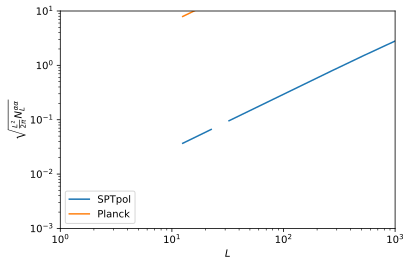

In [54]:
plt.loglog(ell, (ell**2*nl_sptpol/2/np.pi)**0.5/np.radians(1) , label='SPTpol')
plt.loglog(ell, (ell**2*nl_planck/2/np.pi)**0.5/np.radians(1) , label='Planck')
# plt.loglog(ell, (ell**2*nl_sptpol2/2/np.pi)**0.5/np.radians(1), '--', label='SPTpol')
# plt.loglog(ell, (ell**2*nl_planck2/2/np.pi)**0.5/np.radians(1), '--',label='Planck')
# plt.loglog(ell, (ell**2*nl_planck2/2/np.pi)**0.5/np.radians(1), '--',label='Planck')
# plt.loglog(ell, (nl_sptpol), label='SPTpol')
# plt.loglog(ell, (nl_planck), label='Planck')
plt.xlim(1,1000)
plt.ylim(1e-3,1E1)
plt.legend()
plt.xlabel(r'$L$')
plt.ylabel(r'$\sqrt{\frac{L^2}{2\pi} N_{L}^{\alpha\alpha}}$')
plt.savefig('/Users/fbianchini/Desktop/nl_rot2_.pdf')

Text(0,0.5,u'$\\Delta C_{L}^{\\alpha\\alpha}}$ [deg$^2$]')

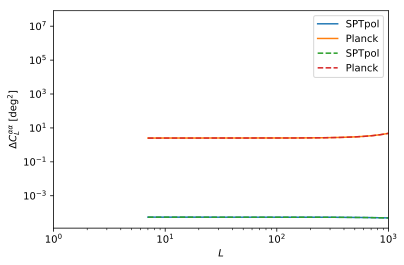

In [158]:
plt.loglog(ell, nl_sptpol/np.radians(1)**2 , label='SPTpol')
plt.loglog(ell, nl_planck/np.radians(1)**2 , label='Planck')
plt.loglog(ell, nl_sptpol2/np.radians(1)**2, '--', label='SPTpol')
plt.loglog(ell, nl_planck2/np.radians(1)**2, '--',label='Planck')
# plt.loglog(ell, (nl_sptpol), label='SPTpol')
# plt.loglog(ell, (nl_planck), label='Planck')
plt.xlim(1,1000)
# plt.ylim(1e-3,10)
plt.legend()
plt.xlabel(r'$L$')
plt.ylabel(r'$\Delta C_{L}^{\alpha\alpha}}$ [deg$^2$]')

/Users/fbianchini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0,0.5,u'$\\sqrt{\\frac{L^2}{2\\pi} N_{L}^{\\alpha\\alpha}}$ [deg]')

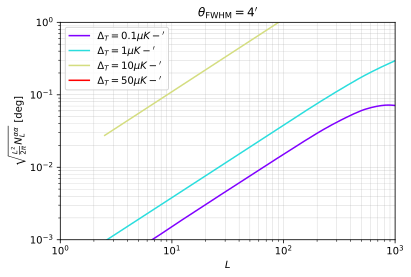

In [240]:
noises = [0.1,1,10,50]
color = iter(cm.rainbow(np.linspace(0,1,len(noises))))

plt.title(r'$\theta_{\rm FWHM}=4^{\prime}$')
for deltaT in noises:
    c=next(color)
    ell, nl = GetNl(cmbspec, deltaT, 4, dx=2.5, nx=500, lbins=np.arange(0,3000,5))
    plt.loglog(ell, (ell**2*nl/2/np.pi)**0.5/np.radians(1), c=c, label=r'$\Delta_T=$'+str(deltaT)+r'$\mu K-^{\prime}$')
plt.xlim(1,1000)
plt.ylim(1e-3,1)
plt.legend()
plt.grid(True,which="both",ls="-", lw=0.25)
plt.xlabel(r'$L$')
plt.ylabel(r'$\sqrt{\frac{L^2}{2\pi} N_{L}^{\alpha\alpha}}$ [deg]')


/Users/fbianchini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/fbianchini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in divide


Text(0,0.5,u'$\\sqrt{\\frac{L^2}{2\\pi} N_{L}^{\\alpha\\alpha}}$ [deg]')

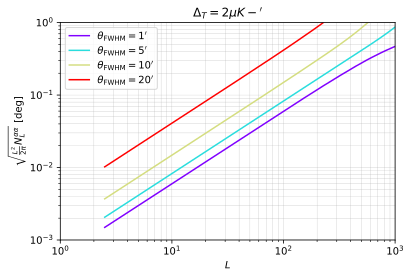

In [241]:
beams = [1, 5, 10, 20]
color = iter(cm.rainbow(np.linspace(0,1,len(beams))))

plt.title(r'$\Delta_T =2\mu K-^{\prime}$')
for beam in beams:
    c=next(color)
    ell, nl = GetNl(cmbspec, 2, beam, dx=2.5, nx=500, lbins=np.arange(0,3000,5))
    plt.loglog(ell, (ell**2*nl/2/np.pi)**0.5/np.radians(1), c=c, label=r'$\theta_{\rm FWHM}=$'+str(beam)+r'$^{\prime}$')
plt.xlim(1,1000)
plt.ylim(1e-3,1)
plt.legend()
plt.grid(True,which="both",ls="-", lw=0.25)
plt.xlabel(r'$L$')
plt.ylabel(r'$\sqrt{\frac{L^2}{2\pi} N_{L}^{\alpha\alpha}}$ [deg]')


In [238]:
nl_no2 = nl.copy()

/Users/fbianchini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/fbianchini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in divide


Text(0,0.5,u'$\\sqrt{\\frac{L^2}{2\\pi} N_{L}^{\\alpha\\alpha}}$ [deg]')

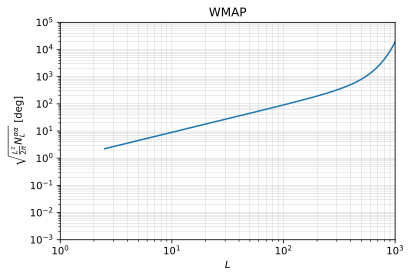

In [233]:
plt.title(r'WMAP')
ell, nl = GetNl(cmbspec, 30., 21., dx=2.5, nx=1000, lbins=np.arange(0,3000,5))
# plt.plot(ell, (nl)**0.5/np.radians(1), )#label=r'$\theta_{\rm FWHM}=$'+str(beam)+r'$^{\prime}$')
plt.loglog(ell, (ell**2*nl/2/np.pi)**0.5/np.radians(1), )#label=r'$\theta_{\rm FWHM}=$'+str(beam)+r'$^{\prime}$')
plt.xlim(1,1000)
plt.ylim(1e-3,1e5)
plt.legend()
plt.grid(True,which="both",ls="-", lw=0.25)
plt.xlabel(r'$L$')
plt.ylabel(r'$\sqrt{\frac{L^2}{2\pi} N_{L}^{\alpha\alpha}}$ [deg]')


In [37]:
@np.vectorize
def v_l_func(lx,ly):
    return np.array([1., np.exp(1j*4*np.arctan2(lx, -ly))])


In [38]:
L  = GetL(512,1,shift=0)
lx, ly = GetLxLy(512,1)

In [5]:
@numba.jit
def ltoi(l, n, dl):
    return ( int(np.round(l[0]/dl) + n/2) , int(np.round(l[1]/dl) + n/2))

@numba.jit
def itol(i, n, dl):
    return ( dl * (i[0] - n/2), dl * (i[1] - n/2) )

@numba.jit
def dotprod(l1, l2):
    return l1[0]*l2[0] + l1[1]*l2[1]

@numba.jit
def anglebetween(l1, l2):
    angle = np.arctan2(l2[1], l2[0]) - np.arctan2(l1[1], l1[0])

    if (angle < 0): angle += 2 * np.pi #// this normalises the angle between [0,2pi)...do we need it?

    return angle

@numba.jit
def circlecheck(l, lmax, lmin):
    return ( (np.hypot(l[0], l[1]) < lmax) and  (np.hypot(l[0], l[1]) > lmin))

@numba.jit
def smallf_EB(l1, l2, eepowerspec2d, bbpowerspec2d,  n,  dl ):
#   // this is f_EB, a.k.a W^{alpha,EB}

    i1 = ltoi(l1, n, dl)
    i2 = ltoi(l2, n, dl)

    bigell_x = l1[0] + l2[0]
    bigell_y = l1[1] + l2[1]
    phi_l1l2 = anglebetween(l1, l2)

#     print i1[0], i1[1], i2[0], i2[1]
    output = 2.* (eepowerspec2d[i1[0]][i1[1]] - bbpowerspec2d[i2[0]][i2[1]]) * np.cos(2.0 * phi_l1l2)

    return output
    
@numba.jit
def filter_EB(l1, l2, eepowerspec2d, bbpowerspec2d, eetotallenspowerspec2d, bbtotallenspowerspec2d,  n,  dl ):

    i1 = ltoi(l1, n, dl)
    i2 = ltoi(l2, n, dl)

    num = smallf_EB(l1, l2, eepowerspec2d, bbpowerspec2d, n, dl )

    if (eetotallenspowerspec2d[i1[0]][i1[1]] == 0.): return 0.
    if (eetotallenspowerspec2d[i2[0]][i2[1]] == 0.): return 0.
    if (bbtotallenspowerspec2d[i1[0]][i1[1]] == 0.): return 0.
    if (bbtotallenspowerspec2d[i2[0]][i2[1]] == 0.): return 0.
  
    denom = eetotallenspowerspec2d[i1[0]][i1[1]] * bbtotallenspowerspec2d[i2[0]][i2[1]]
  
    return num / denom

@numba.jit
def smallf_TB(l1, l2, tepowerspec2d,  n,  dl ):
#   // this is f_TB, a.k.a W^{alpha,TB}

    i1 = ltoi(l1, n, dl)
    i2 = ltoi(l2, n, dl)

    bigell_x = l1[0] + l2[0]
    bigell_y = l1[1] + l2[1]
    phi_l1l2 = anglebetween(l1, l2)

    output = 2.* tepowerspec2d[i1[0]][i1[1]] * np.cos(2.0 * phi_l1l2)

    return output
    
@numba.jit
def filter_TB(l1, l2, tepowerspec2d, tttotallenspowerspec2d, bbtotallenspowerspec2d,  n,  dl ):

    i1 = ltoi(l1, n, dl)
    i2 = ltoi(l2, n, dl)

    num = smallf_TB(l1, l2, tepowerspec2d, n, dl )

    if (tttotallenspowerspec2d[i1[0]][i1[1]] == 0.): return 0.
    if (tttotallenspowerspec2d[i2[0]][i2[1]] == 0.): return 0.
    if (bbtotallenspowerspec2d[i1[0]][i1[1]] == 0.): return 0.
    if (bbtotallenspowerspec2d[i2[0]][i2[1]] == 0.): return 0.
  
    denom = tttotallenspowerspec2d[i1[0]][i1[1]] * bbtotallenspowerspec2d[i2[0]][i2[1]]
  
    return num / denom


@numba.jit#(nopython=1)
def ennellzero_EB_integral(eepowerspec2d, bbpowerspec2d, eetotallenspowerspec2d, bbtotallenspowerspec2d, dl, n, bigell):
    runningtotal = 0.
    usedvals = 0
  
    for i1x in range(n): 
        for i1y in range(n): 
            l1 = itol((i1x,i1y), n, dl)
            l2 = (bigell[0] - l1[0], bigell[1] - l1[1])
            i2 = ltoi(l2, n, dl)
        
            if not(circlecheck(l1, 3000, 0)): continue
            if not(circlecheck(l2, 3000, 0)): continue
                
            if (i1x < 0 or i1x >= n or i2[0] < 0 or i2[0] >= n or i1y < 0 or i1y >= n or i2[1] < 0 or i2[1] >= n ):
#                 print(i1x, i1y, i2)
                continue

            smallfval = smallf_EB(l1, l2, eepowerspec2d, bbpowerspec2d, n, dl )
            filterval = filter_EB(l1, l2, eepowerspec2d, bbpowerspec2d, eetotallenspowerspec2d, bbtotallenspowerspec2d, n, dl )
      
            runningtotal += smallfval * filterval
            usedvals += 1
  
    runningtotal *= dl * dl / (2*np.pi) / (2*np.pi)
    
    if runningtotal == 0.:
        return 0.
    else:
        return 1.0 / runningtotal

@numba.jit#(nopython=1)
def ennellzero_TB_integral(tepowerspec2d, tttotallenspowerspec2d, bbtotallenspowerspec2d, dl, n, bigell):
    runningtotal = 0.
    usedvals = 0
  
    for i1x in range(n): 
        for i1y in range(n): 
            l1 = itol((i1x,i1y), n, dl)
            l2 = (bigell[0] - l1[0], bigell[1] - l1[1])
            i2 = ltoi(l2, n, dl)
        
            if not(circlecheck(l1, 3000, 0)): continue
            if not(circlecheck(l2, 3000, 0)): continue
                
            if (i1x < 0 or i1x >= n or i2[0] < 0 or i2[0] >= n or i1y < 0 or i1y >= n or i2[1] < 0 or i2[1] >= n ):
#                 print(i1x, i1y, i2)
                continue

            smallfval = smallf_TB(l1, l2, tepowerspec2d, n, dl )
            filterval = filter_TB(l1, l2, tepowerspec2d, tttotallenspowerspec2d, bbtotallenspowerspec2d, n, dl )
      
            runningtotal += smallfval * filterval
            usedvals += 1
  
    runningtotal *= dl * dl / (2*np.pi) / (2*np.pi)
    
    if runningtotal == 0.:
        return 0.
    else:
        return 1.0 / runningtotal

    
@numba.jit
def ennellzero_EB(eepowerspec2d, bbpowerspec2d, eetotallenspowerspec2d, bbtotallenspowerspec2d, dl, n, nwanted,):
    output = np.zeros(nwanted)
  
    for ibigell in range(1,nwanted):
        bigell = (dl * ibigell, 0)
#         print bigell
        output[ibigell] = ennellzero_EB_integral(eepowerspec2d, bbpowerspec2d, eetotallenspowerspec2d, bbtotallenspowerspec2d, dl, n, bigell)

    return output

@numba.jit
def ennellzero_TB(tepowerspec2d, tttotallenspowerspec2d, bbtotallenspowerspec2d, dl, n, nwanted):
    output = np.zeros(nwanted)

    for ibigell in range(1,nwanted):
        bigell = (dl * ibigell, 0)
        output[ibigell] = ennellzero_TB_integral(tepowerspec2d, tttotallenspowerspec2d, bbtotallenspowerspec2d, dl, n, bigell)

    return output



In [6]:
dl = 8
n  = 512
nwanted = 200
beam = 1.
noise = 1.

In [7]:
lxgrid, lygrid  = np.meshgrid( np.arange(-n/2.,n/2.)*dl, np.arange(-n/2.,n/2.)*dl )
lgrid = np.sqrt(lxgrid**2 + lygrid**2)
L = np.arange(1,nwanted+1)*dl

In [8]:
nltt = nl_cmb(noise           , beam, cmbspec.shape[0]-1)
nlpp = nl_cmb(noise*np.sqrt(2), beam, cmbspec.shape[0]-1)

ttpowerspec2d = np.interp(lgrid, np.arange(cmbspec.shape[0]), cmbspec[:,0])
eepowerspec2d = np.interp(lgrid, np.arange(cmbspec.shape[0]), cmbspec[:,1])
tepowerspec2d = np.interp(lgrid, np.arange(cmbspec.shape[0]), cmbspec[:,3])
bbpowerspec2d = np.interp(lgrid, np.arange(cmbspec.shape[0]), cmbspec[:,2])
nltt2d        = np.interp(lgrid, np.arange(cmbspec.shape[0]), nltt) 
nlpp2d        = np.interp(lgrid, np.arange(cmbspec.shape[0]), nlpp) 
tttotallenspowerspec2d = ttpowerspec2d.copy() + nltt2d.copy()
bbtotallenspowerspec2d = bbpowerspec2d.copy() + nlpp2d.copy()
eetotallenspowerspec2d = eepowerspec2d.copy() + nlpp2d.copy()


In [10]:
def GimmeNl(cmbspec, beam, noise, est='EB', dl=8, n=512, nwanted=200, f_delens=0., lmax_delens=5000, l_knee=):
    lxgrid, lygrid  = np.meshgrid( np.arange(-n/2.,n/2.)*dl, np.arange(-n/2.,n/2.)*dl )
    lgrid = np.sqrt(lxgrid**2 + lygrid**2)
    L     = np.arange(0,nwanted)*dl    
    ell   = np.arange(0,2001)

    nltt = nl_cmb(noise           , beam, cmbspec.shape[0]-1)
    nlpp = nl_cmb(noise*np.sqrt(2), beam, cmbspec.shape[0]-1)
    
    if est == 'EB':
        clee = cmbspec[:,1].copy()
        clbb = cmbspec[:,2].copy()
        clbb[:lmax_delens+1] = (1.-f_delens)*clbb[:lmax_delens+1]
        
        eepowerspec2d          = np.interp(lgrid, np.arange(cmbspec.shape[0]), clee)
        bbpowerspec2d          = np.interp(lgrid, np.arange(cmbspec.shape[0]), clbb)
        nlpp2d                 = np.interp(lgrid, np.arange(cmbspec.shape[0]), nlpp) 
        eetotallenspowerspec2d = eepowerspec2d.copy() + nlpp2d.copy()
        bbtotallenspowerspec2d = bbpowerspec2d.copy() + nlpp2d.copy()

        nl = ennellzero_EB(eepowerspec2d, bbpowerspec2d, eetotallenspowerspec2d, bbtotallenspowerspec2d, dl, n, nwanted)
#     nl = interpolate.interp1d(L,ennellzero_EB(eepowerspec2d, bbpowerspec2d, eetotallenspowerspec2d, bbtotallenspowerspec2d, dl, n, nwanted), fill_value='extrapolate')
    elif est == 'TB': 
        cltt = cmbspec[:,0].copy()
        clte = cmbspec[:,3].copy()
        clbb = cmbspec[:,2].copy()
        clbb[:lmax_delens+1] = (1.-f_delens)*clbb[:lmax_delens+1]
        
        ttpowerspec2d          = np.interp(lgrid, np.arange(cmbspec.shape[0]), cltt)
        tepowerspec2d          = np.interp(lgrid, np.arange(cmbspec.shape[0]), clte)
        bbpowerspec2d          = np.interp(lgrid, np.arange(cmbspec.shape[0]), clbb)
        nltt2d                 = np.interp(lgrid, np.arange(cmbspec.shape[0]), nltt) 
        nlpp2d                 = np.interp(lgrid, np.arange(cmbspec.shape[0]), nlpp) 
        tttotallenspowerspec2d = ttpowerspec2d.copy() + nltt2d.copy()
        bbtotallenspowerspec2d = bbpowerspec2d.copy() + nlpp2d.copy()
        
        nl = ennellzero_TB(tepowerspec2d, tttotallenspowerspec2d, bbtotallenspowerspec2d, dl, n, nwanted)
    else:
        ValueError
    
    return L, nl
#     return ell, nl(ell)

def GimmeNl_at_L(el, cmbspec, beam, noise, est='EB', dl=8, n=512, f_delens=0., lmax_delens=5000):
    lxgrid, lygrid  = np.meshgrid( np.arange(-n/2.,n/2.)*dl, np.arange(-n/2.,n/2.)*dl )
    lgrid = np.sqrt(lxgrid**2 + lygrid**2)
    L     = np.arange(0,nwanted)*dl    

    nltt = nl_cmb(noise           , beam, cmbspec.shape[0]-1)
    nlpp = nl_cmb(noise*np.sqrt(2), beam, cmbspec.shape[0]-1)
    
    print 'f = %.2f and lmax = %d' %(f_delens, lmax_delens)
    
    if est == 'EB':
        clee = cmbspec[:,1].copy()
        clbb = cmbspec[:,2].copy()
        clbb[:lmax_delens+1] = (1.-f_delens)*clbb[:lmax_delens+1]
#         print clbb
        plt.plot(clbb)
        eepowerspec2d          = np.interp(lgrid, np.arange(cmbspec.shape[0]), clee)
        bbpowerspec2d          = np.interp(lgrid, np.arange(cmbspec.shape[0]), clbb)
        nlpp2d                 = np.interp(lgrid, np.arange(cmbspec.shape[0]), nlpp) 
        eetotallenspowerspec2d = eepowerspec2d.copy() + nlpp2d.copy()
        bbtotallenspowerspec2d = bbpowerspec2d.copy() + nlpp2d.copy()

        nl = ennellzero_EB_integral(eepowerspec2d, bbpowerspec2d, eetotallenspowerspec2d, bbtotallenspowerspec2d, dl, n, (el,0))
    elif est == 'TB': 
        cltt = cmbspec[:,0].copy()
        clte = cmbspec[:,3].copy()
        clbb = cmbspec[:,2].copy()
        clbb[:lmax_delens+1] = (1.-f_delens)*clbb[:lmax_delens+1]
        
        ttpowerspec2d          = np.interp(lgrid, np.arange(cmbspec.shape[0]), cltt)
        tepowerspec2d          = np.interp(lgrid, np.arange(cmbspec.shape[0]), clte)
        bbpowerspec2d          = np.interp(lgrid, np.arange(cmbspec.shape[0]), clbb)
        nltt2d                 = np.interp(lgrid, np.arange(cmbspec.shape[0]), nltt) 
        nlpp2d                 = np.interp(lgrid, np.arange(cmbspec.shape[0]), nlpp) 
        tttotallenspowerspec2d = ttpowerspec2d.copy() + nltt2d.copy()
        bbtotallenspowerspec2d = bbpowerspec2d.copy() + nlpp2d.copy()
        
        nl = ennellzero_TB_integral(tepowerspec2d, tttotallenspowerspec2d, bbtotallenspowerspec2d, dl, n, (el,0))
    else:
        ValueError
    
    return nl

# def GimmeNl_TB(cmbspec, beam, noise, dl, n, nwanted):
#     lxgrid, lygrid  = np.meshgrid( np.arange(-n/2.,n/2.)*dl, np.arange(-n/2.,n/2.)*dl )
#     lgrid = np.sqrt(lxgrid**2 + lygrid**2)
#     L = np.arange(0,nwanted)*dl    
    
#     nltt = nl_cmb(noise           , beam, cmbspec.shape[0]-1)
#     nlpp = nl_cmb(noise*np.sqrt(2), beam, cmbspec.shape[0]-1)
    
#     ttpowerspec2d = np.interp(lgrid, np.arange(cmbspec.shape[0]), cmbspec[:,0])
#     tepowerspec2d = np.interp(lgrid, np.arange(cmbspec.shape[0]), cmbspec[:,3])
#     bbpowerspec2d = np.interp(lgrid, np.arange(cmbspec.shape[0]), cmbspec[:,2])
#     nltt2d        = np.interp(lgrid, np.arange(cmbspec.shape[0]), nltt) 
#     nlpp2d        = np.interp(lgrid, np.arange(cmbspec.shape[0]), nlpp) 
#     tttotallenspowerspec2d = ttpowerspec2d.copy() + nltt2d.copy()
#     bbtotallenspowerspec2d = bbpowerspec2d.copy() + nlpp2d.copy()

# #     ell = np.arange(0,2001)
# #     nl = interpolate.interp1d(L,ennellzero_TB(tepowerspec2d, tttotallenspowerspec2d, bbtotallenspowerspec2d, dl, n, nwanted), fill_value='extrapolate')
    
# #     return ell, nl(ell)
#     return L, ennellzero_TB(tepowerspec2d, tttotallenspowerspec2d, bbtotallenspowerspec2d, dl, n, nwanted)

SyntaxError: invalid syntax (<ipython-input-10-4119a4389d39>, line 1)

In [36]:
%timeit ennellzero_TB(tepowerspec2d, tttotallenspowerspec2d, bbtotallenspowerspec2d, dl, n, nwanted)

1 loop, best of 3: 13.3 s per loop


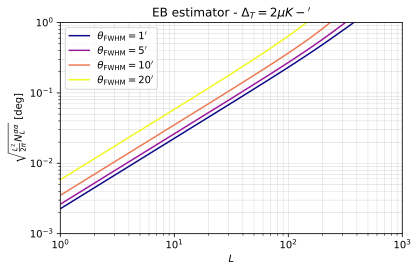

In [15]:
beams = [1, 5, 10, 20]
color = iter(cm.plasma(np.linspace(0,1,len(beams))))

ell = np.arange(0,2001)

plt.title(r'EB estimator - $\Delta_T =2\mu K-^{\prime}$')
for beam in beams:
    c=next(color)
    L, NL = GimmeNl(cmbspec, beam, 2, est='EB')
    nl_tmp = interpolate.interp1d(L, (L**2*NL/2/np.pi)**0.5/np.radians(1), fill_value='extrapolate')
    plt.loglog(ell, nl_tmp(ell), c=c, label=r'$\theta_{\rm FWHM}=$'+str(beam)+r'$^{\prime}$')
plt.xlim(1,1000)
plt.ylim(1e-3,1)
plt.legend()
plt.grid(True,which="both",ls="-", lw=0.25)
plt.xlabel(r'$L$')
plt.ylabel(r'$\sqrt{\frac{L^2}{2\pi} N_{L}^{\alpha\alpha}}$ [deg]')
plt.tight_layout()
plt.savefig('/Users/fbianchini/Research/CosmicRotation/beams_dl8_n512_nwant200_lmax3000_EB.pdf')

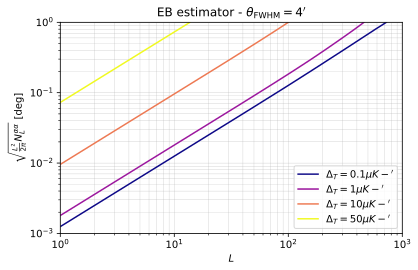

In [17]:
noises = [0.1,1,10,50]
color = iter(cm.plasma(np.linspace(0,1,len(noises))))

ell = np.arange(0,2001)

plt.title(r'EB estimator - $\theta_{\rm FWHM}=4^{\prime}$')
for deltaT in noises:
    c=next(color)
    L, NL = GimmeNl(cmbspec, 4., deltaT, est='EB')
    nl_tmp = interpolate.interp1d(L, (L**2*NL/2/np.pi)**0.5/np.radians(1), fill_value='extrapolate')
    plt.loglog(ell, nl_tmp(ell), c=c, label=r'$\Delta_T=$'+str(deltaT)+r'$\mu K-^{\prime}$')
plt.xlim(1,1000)
plt.ylim(1e-3,1)
plt.legend()
plt.grid(True,which="both",ls="-", lw=0.25)
plt.xlabel(r'$L$')
plt.ylabel(r'$\sqrt{\frac{L^2}{2\pi} N_{L}^{\alpha\alpha}}$ [deg]')
plt.tight_layout()
plt.savefig('/Users/fbianchini/Research/CosmicRotation/noises_dl8_n512_nwant200_lmax3000_EB.pdf')

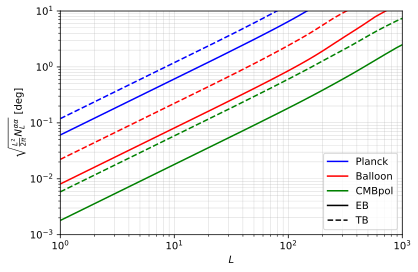

In [18]:
l_, nl_planck_EB = GimmeNl(cmbspec, 7., 40., est='EB')
l_, nl_ballon_EB = GimmeNl(cmbspec, 8., 9.6/np.sqrt(2), est='EB')
l_, nl_cmbpol_EB = GimmeNl(cmbspec, 4., 1., est='EB')

l_, nl_planck_TB = GimmeNl(cmbspec, 7., 40., est='TB')
l_, nl_ballon_TB = GimmeNl(cmbspec, 8., 9.6/np.sqrt(2), est='TB')
l_, nl_cmbpol_TB = GimmeNl(cmbspec, 4., 1., est='TB')

nl_planck_EB_int = interpolate.interp1d(l_, (l_**2*nl_planck_EB/2/np.pi)**0.5/np.radians(1), fill_value='extrapolate')
nl_ballon_EB_int = interpolate.interp1d(l_, (l_**2*nl_ballon_EB/2/np.pi)**0.5/np.radians(1), fill_value='extrapolate')
nl_cmbpol_EB_int = interpolate.interp1d(l_, (l_**2*nl_cmbpol_EB/2/np.pi)**0.5/np.radians(1), fill_value='extrapolate')

nl_planck_TB_int = interpolate.interp1d(l_, (l_**2*nl_planck_TB/2/np.pi)**0.5/np.radians(1), fill_value='extrapolate')
nl_ballon_TB_int = interpolate.interp1d(l_, (l_**2*nl_ballon_TB/2/np.pi)**0.5/np.radians(1), fill_value='extrapolate')
nl_cmbpol_TB_int = interpolate.interp1d(l_, (l_**2*nl_cmbpol_TB/2/np.pi)**0.5/np.radians(1), fill_value='extrapolate')

ell = np.arange(0,2001)

plt.loglog(ell, nl_planck_EB_int(ell), 'b-', label=r'Planck')
plt.loglog(ell, nl_ballon_EB_int(ell), 'r-', label=r'Balloon')
plt.loglog(ell, nl_cmbpol_EB_int(ell), 'g-', label=r'CMBpol')

plt.loglog(ell, nl_planck_TB_int(ell), 'b--')#, label=r'Planck')
plt.loglog(ell, nl_ballon_TB_int(ell), 'r--')#, label=r'Ballon')
plt.loglog(ell, nl_cmbpol_TB_int(ell), 'g--')#, label=r'CMBpol')

# plt.loglog(l_, (l_**2*nl_planck_EB/2/np.pi)**0.5/np.radians(1), 'b-', label=r'Planck')
# plt.loglog(l_, (l_**2*nl_ballon_EB/2/np.pi)**0.5/np.radians(1), 'r-', label=r'Balloon')
# plt.loglog(l_, (l_**2*nl_cmbpol_EB/2/np.pi)**0.5/np.radians(1), 'g-', label=r'CMBpol')

# plt.loglog(l_, (l_**2*nl_planck_TB/2/np.pi)**0.5/np.radians(1), 'b--',)# label=r'Planck')
# plt.loglog(l_, (l_**2*nl_ballon_TB/2/np.pi)**0.5/np.radians(1), 'r--',)# label=r'Balloon')
# plt.loglog(l_, (l_**2*nl_cmbpol_TB/2/np.pi)**0.5/np.radians(1), 'g--',)# label=r'CMBpol')

plt.plot(-100,-100, 'k-', label='EB')
plt.plot(-100,-100, 'k--', label='TB')

plt.xlim(1,1000)
plt.ylim(1e-3,10)
plt.legend()
plt.grid(True,which="both",ls="-", lw=0.25)
plt.xlabel(r'$L$')
plt.ylabel(r'$\sqrt{\frac{L^2}{2\pi} N_{L}^{\alpha\alpha}}$ [deg]')
plt.tight_layout()
plt.savefig('/Users/fbianchini/Research/CosmicRotation/fig1_yadav_dl8_n512_nwant200_lmax3000_EB_TB.pdf')

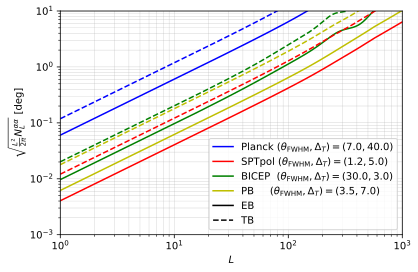

In [67]:
dl = 8
n  = 512

l_, nl_planck_EB = GimmeNl(cmbspec, 7., 40.,  est='EB')
l_, nl_sptpol_EB = GimmeNl(cmbspec, 1.2,  5,  est='EB')
l_, nl_bicep_EB  = GimmeNl(cmbspec, 30.,  3,  est='EB')
l_, nl_polar_EB  = GimmeNl(cmbspec, 3.5,  7,  est='EB')

l_, nl_planck_TB = GimmeNl(cmbspec, 7., 40.,  est='TB')
l_, nl_sptpol_TB = GimmeNl(cmbspec, 1.2,  5,  est='TB')
l_, nl_bicep_TB  = GimmeNl(cmbspec, 30.,  3,  est='TB')
l_, nl_polar_TB  = GimmeNl(cmbspec, 3.5,  7,  est='TB')

ell = np.arange(0,2001)
nl_planck_EB_int = interpolate.interp1d(l_, (l_**2*nl_planck_EB/2/np.pi)**0.5/np.radians(1), fill_value='extrapolate')
nl_planck_TB_int = interpolate.interp1d(l_, (l_**2*nl_planck_TB/2/np.pi)**0.5/np.radians(1), fill_value='extrapolate')
nl_sptpol_EB_int = interpolate.interp1d(l_, (l_**2*nl_sptpol_EB/2/np.pi)**0.5/np.radians(1), fill_value='extrapolate')
nl_sptpol_TB_int = interpolate.interp1d(l_, (l_**2*nl_sptpol_TB/2/np.pi)**0.5/np.radians(1), fill_value='extrapolate')
nl_bicep_EB_int  = interpolate.interp1d(l_, (l_**2*nl_bicep_EB/2/np.pi)**0.5/np.radians(1), fill_value='extrapolate')
nl_bicep_TB_int  = interpolate.interp1d(l_, (l_**2*nl_bicep_TB/2/np.pi)**0.5/np.radians(1), fill_value='extrapolate')
nl_polar_EB_int  = interpolate.interp1d(l_, (l_**2*nl_polar_EB/2/np.pi)**0.5/np.radians(1), fill_value='extrapolate')
nl_polar_TB_int  = interpolate.interp1d(l_, (l_**2*nl_polar_TB/2/np.pi)**0.5/np.radians(1), fill_value='extrapolate')

plt.loglog(ell, nl_planck_EB_int(ell), 'b-', label=r'Planck $(\theta_{\rm FWHM},\Delta_T)=(%.1f,%.1f)$' %(7.,40))
plt.loglog(ell, nl_sptpol_EB_int(ell), 'r-', label=r'SPTpol $(\theta_{\rm FWHM},\Delta_T)=(%.1f,%.1f)$' %(1.2,5))
plt.loglog(ell, nl_bicep_EB_int(ell),  'g-', label=r'BICEP  $(\theta_{\rm FWHM},\Delta_T)=(%.1f,%.1f)$' %(30,3))
plt.loglog(ell, nl_polar_EB_int(ell),  'y-', label=r'PB     $(\theta_{\rm FWHM},\Delta_T)=(%.1f,%.1f)$' %(3.5,7))

plt.loglog(ell, nl_planck_TB_int(ell), 'b--',)# label=r'Planck')
plt.loglog(ell, nl_sptpol_TB_int(ell), 'r--',)# label=r'Balloon')
plt.loglog(ell, nl_bicep_TB_int(ell) , 'g--',)# label=r'Balloon')
plt.loglog(ell, nl_polar_TB_int(ell) , 'y--',)# label=r'Balloon')

# ell = np.arange(1000)
# plt.loglog(ell, (ell**2*np.interp(ell, l_, nl_planck)/2/np.pi)**0.5/np.radians(1), label=r'Planck')
# plt.loglog(ell, (ell**2*np.interp(ell, l_, nl_ballon)/2/np.pi)**0.5/np.radians(1), label=r'Balloon')
# plt.loglog(ell, (ell**2*np.interp(ell, l_, nl_cmbpol)/2/np.pi)**0.5/np.radians(1), label=r'CMBpol')

plt.plot(-100,-100, 'k-', label='EB')
plt.plot(-100,-100, 'k--', label='TB')

plt.xlim(1,1000)
plt.ylim(1e-3,10)
plt.legend()
plt.grid(True,which="both",ls="-", lw=0.25)
plt.xlabel(r'$L$')
plt.ylabel(r'$\sqrt{\frac{L^2}{2\pi} N_{L}^{\alpha\alpha}}$ [deg]')
plt.tight_layout()
plt.savefig('/Users/fbianchini/Research/CosmicRotation/planck_sptpol_bicep_polarbear_dl8_n512_nwant200_lmax3000_EB_TB.pdf')

In [95]:
nl_planck_EB.shape

(200,)

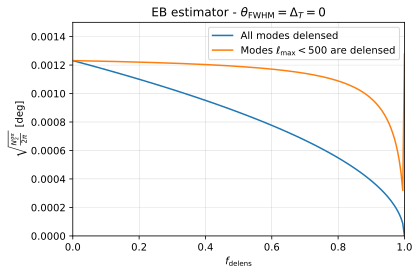

In [241]:
fs_delens = np.linspace(0,1,200,endpoint=1)
# fs_delens = [0.1, 0.5]

color = iter(cm.plasma_r(np.linspace(0.,1,len(fs_delens))))

nls      = np.zeros_like(fs_delens)
nls_lmax = np.zeros_like(fs_delens)


plt.title(r'EB estimator - $\theta_{\rm FWHM}=\Delta_T = 0$')
for idf, f in enumerate(fs_delens):
    nls[idf]      = GimmeNl_at_L(2., cmbspec, 0., 0., est='EB', f_delens=f,)
    nls_lmax[idf] = GimmeNl_at_L(2., cmbspec, 0., 0., est='EB', f_delens=f, lmax_delens=500)

plt.plot(fs_delens, np.sqrt(nls/2/np.pi)/np.radians(1), label='All modes delensed')
plt.plot(fs_delens, np.sqrt(nls_lmax/2/np.pi)/np.radians(1), label=r'Modes $\ell_{\rm max}<500$ are delensed')
plt.xlim(0,1)
plt.ylim(0,0.0015)
plt.legend()
plt.grid(True,which="both",ls="-", lw=0.25)
plt.xlabel(r'$f_{\rm delens}$')
plt.ylabel(r'$\sqrt{\frac{N_{2}^{\alpha\alpha}}{2\pi}}$ [deg]')
plt.tight_layout()
plt.savefig('/Users/fbianchini/Research/CosmicRotation/EB_delens_l2_noise0_beam0.pdf')

In [231]:
print GimmeNl_at_L(2., cmbspec, 0., 0., est='EB', f_delens=0.9, lmax_delens=6000)
print GimmeNl_at_L(2., cmbspec, 0., 0., est='EB', f_delens=0.9, lmax_delens=5000)
# plt.colorbar()
# plt.loglog(cmbspec[:,2], '--')

2.31987244942e-08
2.31987244942e-08


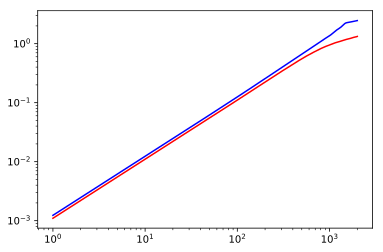

In [249]:
# lf, nl_fine   = GimmeNl(cmbspec, 0.,  0.,  est='EB', dl=8,  n=512)
lc, nl_coarse = GimmeNl(cmbspec, 0.,  0.,  est='EB', dl=50, n=512)

ell = np.arange(0,2001)
# nl_fine_int   = interpolate.interp1d(lf, (lf**2*nl_fine/2/np.pi)**0.5/np.radians(1), fill_value='extrapolate')
nl_coarse_int = interpolate.interp1d(lc, (lc**2*nl_coarse/2/np.pi)**0.5/np.radians(1), fill_value='extrapolate')

plt.loglog(ell, nl_fine_int(ell), 'b-', )#label=r'Planck $(\theta_{\rm FWHM},\Delta_T)=(%.1f,%.1f)$' %(7.,40))
plt.loglog(ell, nl_coarse_int(ell), 'r-', )#label=r'SPTpol $(\theta_{\rm FWHM},\Delta_T)=(%.1f,%.1f)$' %(1.2,5))


/Users/fbianchini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.


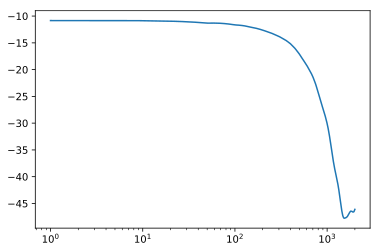

In [250]:
plt.semilogx((nl_coarse_int(ell)/nl_fine_int(ell)-1)*100)

In [55]:
nltt = nl_cmb(45, 5, 5000)
nlpp = nl_cmb(5*np.sqrt(2), 1.2, cmbspec.shape[0]-1)


In [83]:
np.radians(1)**2

0.00030461741978670857

In [28]:
dx = 1; nx = 2048*2
tfac = np.sqrt((np.radians(dx/60.)**2) / (nx**2))

In [29]:
tfac

7.1017629068779683e-08

In [12]:
FT = FlatMapFFT(1024, 1, map=FlatMapReal(1024,1,map=x))


In [13]:
EL, CL = FT.GetCl(lbins=np.arange(0,3000,10))

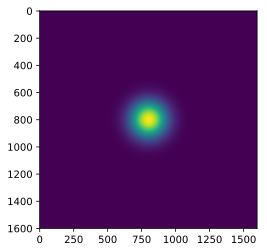

In [81]:
plt.imshow(np.fft.fftshift(np.fft.fft2(np.fft.ifft2(xa).real*np.fft.ifft2(xb).real).real))

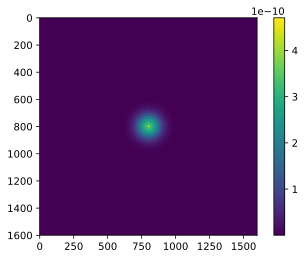

In [58]:
plt.imshow(np.fft.fftshift(np.fft.fft2(np.fft.ifft2(xa).real*np.fft.ifft2(ya).real).real)); plt.colorbar()

In [71]:
Lx,Ly = GetLxLy(800,1)

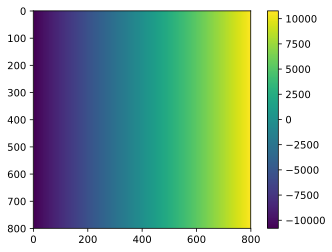

In [75]:
plt.imshow(np.fft.fftshift(Lx));plt.colorbar()

In [43]:
np.exp(4*1j*GetLxLyAngle(512,2)).imag.max()

0.99999999984531074

In [6]:
lrange = np.arange(10000)
claa = np.nan_to_num(1e-5*2*np.pi/lrange/(lrange+1))
claa[0] = 0.

/Users/fbianchini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  


In [7]:
alpha = GenCorrFlatMaps(claa, nx=512, dx=1)

In [8]:
Emap = GenCorrFlatMaps(cmbspec[:,1], nx=512, dx=1)

In [9]:
Bmap = np.zeros_like(Emap)

In [10]:
Qmap, Umap = EB2QU(Emap, Bmap, 1)

In [11]:
def RotateMe(mapQ, mapU, mapAlpha):
    mapQ_rot = np.cos(2*mapAlpha)*mapQ + np.sin(2*mapAlpha)*mapU
    mapU_rot = np.cos(2*mapAlpha)*mapU - np.sin(2*mapAlpha)*mapQ
    return mapQ_rot, mapU_rot

In [12]:
QmapRot, UmapRot = RotateMe(Qmap, Umap, alpha)#np.ones_like(Qmap)*1)

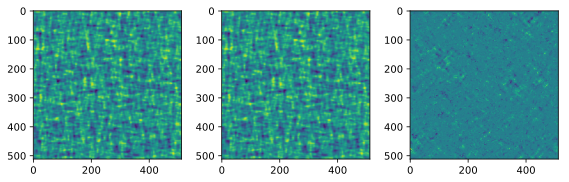

In [160]:
plt.figure(figsize=(8,14))
plt.subplot(131); plt.imshow(Qmap)
plt.subplot(132); plt.imshow(QmapRot)
plt.subplot(133); plt.imshow(Qmap - QmapRot)
plt.tight_layout()

In [13]:
EmapRot, BmapRot = QU2EB(QmapRot, UmapRot, 1)

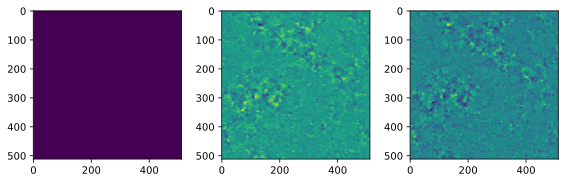

In [293]:
plt.figure(figsize=(8,14))
plt.subplot(131); plt.imshow(Bmap)
plt.subplot(132); plt.imshow(BmapRot)
plt.subplot(133); plt.imshow(Bmap - BmapRot)
plt.tight_layout()

In [295]:
myft = FlatMapFFT(512, 1, map=FlatMapReal(512,1,EmapRot))

In [347]:
alphabar = GetAlphaBar(FlatMapReal(512,1,EmapRot), FlatMapReal(512,1,BmapRot), cmbspec, 0., 0.,)

/Users/fbianchini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in divide
  
/Users/fbianchini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app
/Users/fbianchini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()
/Users/fbianchini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in divide


[[  0.00000000e+00 +0.00000000e+00j  -5.13249139e-24 +6.28548915e-40j
   -1.04780029e-24 +1.28318527e-40j ...,  -4.73437972e-23 -5.79794297e-39j
   -1.04780029e-24 -1.28318527e-40j  -5.13249138e-24 -6.28548914e-40j]
 [  9.34811649e-24 -2.28962819e-39j  -9.08369609e-35 -4.94493383e-19j
   -2.95818062e-19 -3.94424082e-19j ...,  -2.57372858e-20 +1.93029643e-20j
   -1.08467123e-19 +1.44622831e-19j  -1.05316927e-35 +5.73318650e-20j]
 [  2.76234290e-23 -6.76578879e-39j   8.37016577e-20 -1.11602210e-19j
   -6.64430435e-36 -3.61699082e-20j ...,  -3.00154863e-20 +7.20371671e-20j
   -3.01945031e-35 +1.64371219e-19j   5.84154864e-20 +7.78873152e-20j]
 ..., 
 [  1.46685727e-23 +0.00000000e+00j   3.17849498e-19 +2.38387124e-19j
    3.85698494e-20 +9.25676386e-20j ...,   4.63220357e-36 -7.56496253e-20j
    6.40574977e-21 -1.53737995e-20j   6.48906219e-21 -4.86679664e-21j]
 [  2.76234290e-23 +0.00000000e+00j   5.84154864e-20 +7.78873152e-20j
    1.00648344e-35 +1.64371219e-19j ...,  -2.74904340e-20 -

In [317]:
def GetAlphaBar(mapE, mapB, cmbspec, noise, beam, lmax=None, lbins=np.arange(0,5000.,5)):
    if lmax is None:
        lmax = cmbspec.shape[0]-1
        
    ftE = FlatMapFFT(mapE.nx, mapE.dx*rad2arcmin, map=mapE)
    ftB = FlatMapFFT(mapB.nx, mapB.dx*rad2arcmin, map=mapB)
    
    E_l = ftE.Get2DSpectra()
    B_l = ftB.Get2DSpectra()

    nltt = nl_cmb(noise, beam, lmax)
    nlpp = nl_cmb(noise*np.sqrt(2), beam, lmax)
    
    X_E1 = cmbspec[:,1]**2/(cmbspec[:,1]+nlpp)
    X_B1 = 1./(cmbspec[:,2]+nlpp)
    X_E2 = 1./(cmbspec[:,1]+nlpp)
    X_B2 = -cmbspec[:,2]**2/(cmbspec[:,2]+nlpp)
    
#     nx = nx*2
#     dx = dx
    L  = GetL(ftE.nx, ftE.dx*rad2arcmin,shift=0)

    ang_plus  = np.exp(2*1j *GetLxLyAngle(ftE.nx, ftE.dx*rad2arcmin, shift=0))
    ang_minus = np.exp(-2*1j*GetLxLyAngle(ftE.nx, ftE.dx*rad2arcmin, shift=0))
    
    X_l_E1 = np.nan_to_num(np.interp(L, np.arange(len(nltt)), X_E1) * ang_plus  * E_l)
    X_l_B1 = np.nan_to_num(np.interp(L, np.arange(len(nltt)), X_B1) * ang_minus * B_l)
    X_l_E2 = np.nan_to_num(np.interp(L, np.arange(len(nltt)), X_E2) * ang_plus  * E_l)
    X_l_B2 = np.nan_to_num(np.interp(L, np.arange(len(nltt)), X_B2) * ang_minus * B_l)

    print X_l_E1
#     tfac = ((np.radians(dx/60.)**2) / (nx**2))
#     
    return 2.*( np.fft.fft((np.fft.ifft2(X_l_E1) * np.fft.ifft2(X_l_B1)).real) + np.fft.fft((np.fft.ifft2(X_l_E2) * np.fft.ifft2(X_l_B2)).real) )


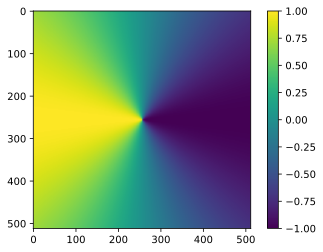

In [340]:
plt.imshow(np.exp(-1j*GetLxLyAngle(512,2,shift=1)).imag);plt.colorbar()

In [333]:
def GetLxLyAngle(nx, dx, ny=None, dy=None, shift=False):
    """ 
    Returns a grid with the angle between Fourier mode in the map. 
    If shift=True (default), \ell = 0 is centered in the grid
    ~ Note: already multiplied by 2\pi 
    """
    lx, ly = GetLxLy(nx, dx, ny=ny, dy=dy, shift=shift)
    return np.arctan2(lx, -ly)


In [348]:
np.isclose(np.exp(-1j*GetLxLyAngle(512,2,shift=1)).imag, np.exp(1j*GetLxLyAngle(512,2,shift=1)).imag).all()

False

In [32]:
from camb.bispectrum import threej

In [33]:
def F(l2,l3,s):
    l1 = np.arange(np.abs(l2-l3),l2+l3+1)
    return (-l1*(l1+1)+l2*(l2+1)+l3*(l3+1))*np.sqrt((2*l1+1)*(2*l2+1)*(2*l3+1)/16/np.pi)*threej(l2,l3,-s,s)

In [7]:
def f_EB_lens(l2,l3):
    return (F(l2,l3,-2) - F(l2,l3,+2))/(2.*1j)

In [8]:
f_EB_lens(2,5)

array([ 0.+0.j        ,  0.+9.29655619j,  0.+0.j        ,  0.-2.65552033j,
        0.+0.j        ])

In [9]:
def C_ell_res(cmbspec, noise=0., beam=0., lmax=1000):
    ell  = np.arange(cmbspec.shape[0])
    clee = cmbspec[:,1].copy()
    clpp = cmbspec[:,4].copy()/(ell*(ell+1))**2*4
#     nlee = np.zeros_like(clee)
    nlee = nl_cmb(noise*np.sqrt(2), beam, cmbspec.shape[0]-1)
    nlpp = np.zeros_like(clpp)
    clbb_res = np.zeros(3000+1)
#     plt.loglog(clpp)
    for l2 in xrange(2,lmax+1):
#         if l2 < 2: continue
        for l3 in xrange(2,lmax+1):
#             if l3 < 2: continue
            l1min = np.abs(l2-l3)
            l1max = l2+l3
            l1   = np.arange(l1min,l1max+1)
#             if l1.max() > 3000:
#                 print l2,l3
#             print l1.max()
#             print l2,l3, lmin, lmax
#             print clbb_res[11]
#             print clbb_res[l1]#f_EB_lens(l2,l3)**2
#             print l2, l3, (clee[l2]*clpp[l3] - (clee[l2]**2/(clee[l2]+nlee[l2]))*(clpp[l3]**2/(clpp[l3]+nlpp[l3])))
            clbb_res[l1] += ( np.abs(f_EB_lens(l2,l3))**2 * ( clee[l2]*clpp[l3] - (clee[l2]**2/(clee[l2]+nlee[l2])) * (clpp[l3]**2/(clpp[l3]+nlpp[l3])) ) )
            
    return clbb_res / (2*np.arange(clbb_res.size)+1)

In [12]:
clbb_delens_noise = C_ell_res(cmbspec, noise=1., beam=1.)

/Users/fbianchini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


(2, 1000)

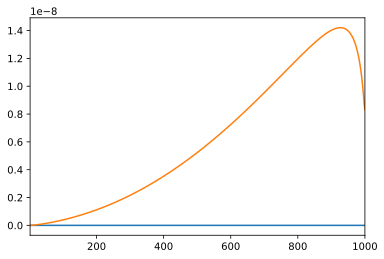

In [13]:
plt.plot(clbb_delens)
plt.plot(clbb_delens_noise)
plt.xlim(2,1000)

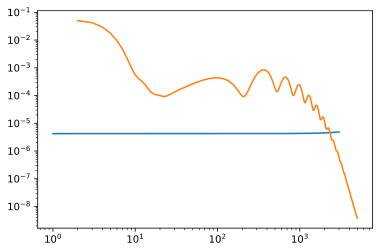

In [17]:
plt.loglog(nl_cmb(np.sqrt(2)*5, 1))
plt.loglog(cmbspec[:,1])

In [44]:
@numba.jit
def W_delens(l1, l2,  n,  dl ):
#   // this is W_EB

    i1 = ltoi(l1, n, dl)
    i2 = ltoi(l2, n, dl)

    bigell_x = l1[0] - l2[0]
    bigell_y = l1[1] - l2[1]
    bigell   = (bigell_x, bigell_y)
    phi_l1l2 = anglebetween(l1, l2)

#     print i1[0], i1[1], i2[0], i2[1]
#     output =  2. * dotprod(l2,bigell) * np.sin(2.0 * phi_l1l2) / dotprod(bigell,bigell)
    output =  dotprod(l2,bigell) * np.sin(2.0 * phi_l1l2) 

    return output

@numba.jit#(nopython=1)
def Cl_BB_res_integral(eepowerspec2d, kkpowerspec2d, eetotallenspowerspec2d, dl, n, l):
    runningtotal = 0.
    usedvals = 0

    il = ltoi(l, n, dl)

    for ipx in range(n): 
        for ipy in range(n): 
            lp = itol((ipx,ipy), n, dl)
            l_min_lp = (l[0] - lp[0], l[1] - lp[1])
            il_min_ilp = ltoi(l_min_lp, n, dl)
        
#             print lp, l, l_min_lp
            if not(circlecheck(lp, 3000, 0)): continue
            if not(circlecheck(l_min_lp, 3000, 0)): continue
                
            if (ipx < 0 or ipx >= n or il_min_ilp[0] < 0 or il_min_ilp[0] >= n or ipy < 0 or ipy >= n or il_min_ilp[1] < 0 or il_min_ilp[1] >= n ):
#                 print(i1x, i1y, i2)
                continue
            
#             print eepowerspec2d[ipx][ipy]
#             print kkpowerspec2d[il[0]][il[1]] 
#             print W_delens(l, lp,  n,  dl )**2
            runningtotal += eepowerspec2d[ipx,ipy] * kkpowerspec2d[il_min_ilp[0]][il_min_ilp[1]] * W_delens(l, lp,  n,  dl )**2 * (1. - eepowerspec2d[ipx][ipy]/eetotallenspowerspec2d[ipx][ipy])
            usedvals += 1
#             print (1. - eepowerspec2d[ipx][ipy]/eetotallenspowerspec2d[ipx][ipy])
  
    runningtotal *= dl * dl / (2*np.pi) / (2*np.pi)
    
    if runningtotal == 0.:
        return 0.
    else:
        return runningtotal

@numba.jit
def ClBB_res(eepowerspec2d, kkpowerspec2d, eetotallenspowerspec2d, dl, n, nwanted,):
    output = np.zeros(nwanted)
  
    for iell in range(1,nwanted):
        ell = (dl * iell, 0)
#         print bigell
        output[iell] = Cl_BB_res_integral(eepowerspec2d, kkpowerspec2d, eetotallenspowerspec2d, dl, n, ell)

    return output

@numba.jit
def Cl_BB_lens_integral(eepowerspec2d, kkpowerspec2d, dl, n, l):
    runningtotal = 0.
    usedvals = 0

    il = ltoi(l, n, dl)

    for ipx in range(n): 
        for ipy in range(n): 
            lp = itol((ipx,ipy), n, dl)
            l_min_lp = (l[0] - lp[0], l[1] - lp[1])
            il_min_ilp = ltoi(l_min_lp, n, dl)
        
            if not(circlecheck(lp, 3000, 0)): continue
            if not(circlecheck(l_min_lp, 3000, 0)): continue
                
            if (ipx < 0 or ipx >= n or il_min_ilp[0] < 0 or il_min_ilp[0] >= n or ipy < 0 or ipy >= n or il_min_ilp[1] < 0 or il_min_ilp[1] >= n ):
                continue
            
            runningtotal += eepowerspec2d[ipx,ipy] * kkpowerspec2d[il_min_ilp[0]][il_min_ilp[1]] * W_delens(l, lp,  n,  dl )**2
            usedvals += 1
  
    runningtotal *= dl * dl / (2*np.pi) / (2*np.pi)
    
    if runningtotal == 0.:
        return 0.
    else:
        return runningtotal

@numba.jit
def ClBB_lens(eepowerspec2d, kkpowerspec2d, dl, n, nwanted,):
    output = np.zeros(nwanted)
  
    for iell in range(1,nwanted):
        ell = (dl * iell, 0)
#         print bigell
        output[iell] = Cl_BB_lens_integral(eepowerspec2d, kkpowerspec2d, dl, n, ell)

    return output

@numba.jit
def W_rot(l1, l2,  n,  dl ):
#   // this is W_EB

    i1 = ltoi(l1, n, dl)
    i2 = ltoi(l2, n, dl)

    phi_l1l2 = anglebetween(l1, l2)

    output =  2. * np.cos(2.0 * phi_l1l2) 

    return output

@numba.jit
def Cl_BB_rot_integral(eepowerspec2d, alphaalphapowerspec2d, dl, n, l):
    runningtotal = 0.
    usedvals = 0

    il = ltoi(l, n, dl)

    for ipx in range(n): 
        for ipy in range(n): 
            lp = itol((ipx,ipy), n, dl)
            l_min_lp = (l[0] - lp[0], l[1] - lp[1])
            il_min_ilp = ltoi(l_min_lp, n, dl)
        
            if not(circlecheck(lp, 3000, 0)): continue
            if not(circlecheck(l_min_lp, 3000, 0)): continue
                
            if (ipx < 0 or ipx >= n or il_min_ilp[0] < 0 or il_min_ilp[0] >= n or ipy < 0 or ipy >= n or il_min_ilp[1] < 0 or il_min_ilp[1] >= n ):
                continue
            
            runningtotal += eepowerspec2d[ipx,ipy] * alphaalphapowerspec2d[il_min_ilp[0]][il_min_ilp[1]] * W_rot(l, lp,  n,  dl )**2
            usedvals += 1
  
    runningtotal *= dl * dl / (2*np.pi) / (2*np.pi)
    
    if runningtotal == 0.:
        return 0.
    else:
        return runningtotal

@numba.jit
def ClBB_rot(eepowerspec2d, alphaalphapowerspec2d, dl, n, nwanted,):
    output = np.zeros(nwanted)
  
    for iell in range(1,nwanted):
        ell = (dl * iell, 0)
#         print bigell
        output[iell] = Cl_BB_rot_integral(eepowerspec2d, alphaalphapowerspec2d, dl, n, ell)

    return output

In [46]:
def GimmeClBBRes(cmbspec, beam, noise, dl=8, n=512, nwanted=200):
    lxgrid, lygrid  = np.meshgrid( np.arange(-n/2.,n/2.)*dl, np.arange(-n/2.,n/2.)*dl )
    lgrid = np.sqrt(lxgrid**2 + lygrid**2)
    L     = np.arange(0,nwanted)*dl    
    ell   = np.arange(0,2001)

    nlpp = nl_cmb(noise*np.sqrt(2), beam, cmbspec.shape[0]-1)
    
    clee = cmbspec[:,1].copy()
    
    eepowerspec2d          = np.interp(lgrid, np.arange(cmbspec.shape[0]), clee)
    nlpp2d                 = np.interp(lgrid, np.arange(cmbspec.shape[0]), nlpp) 
    eetotallenspowerspec2d = eepowerspec2d.copy() + nlpp2d.copy()

    
    ell  = np.arange(cmbspec.shape[0])
    clkk = cmbspec[:,4].copy()
    clpp = cmbspec[:,4].copy()/(ell*(ell+1))**2*4

    kkpowerspec2d = np.interp(lgrid, np.arange(cmbspec.shape[0]), clpp)
    
#     plt.loglog(clpp)
#     plt.loglog(clee)
#     plt.loglog(nlpp)

#     plt.imshow(eepowerspec2d/eetotallenspowerspec2d)
#     plt.colorbar()
#     bbtotallenspowerspec2d = bbpowerspec2d.copy() + nlpp2d.copy()

    clres = ClBB_res(eepowerspec2d, kkpowerspec2d, eetotallenspowerspec2d, dl, n, nwanted)
    
    return L, clres

def GimmeClBBLens(cmbspec, dl=8, n=512, nwanted=200):
    lxgrid, lygrid  = np.meshgrid( np.arange(-n/2.,n/2.)*dl, np.arange(-n/2.,n/2.)*dl )
    lgrid = np.sqrt(lxgrid**2 + lygrid**2)
    L     = np.arange(0,nwanted)*dl    
    
    clee = cmbspec[:,1].copy()
    
    eepowerspec2d = np.interp(lgrid, np.arange(cmbspec.shape[0]), clee)
    
    ell  = np.arange(cmbspec.shape[0])
    clkk = cmbspec[:,4].copy()
    clpp = cmbspec[:,4].copy()/(ell*(ell+1))**2*4

    kkpowerspec2d = np.interp(lgrid, np.arange(cmbspec.shape[0]), clpp)
    
    cllens = ClBB_lens(eepowerspec2d, kkpowerspec2d, dl, n, nwanted)
    
    return L, cllens

def GimmeClBBRot(cmbspec, A_CB=1., dl=8, n=512, nwanted=200):
    lxgrid, lygrid  = np.meshgrid( np.arange(-n/2.,n/2.)*dl, np.arange(-n/2.,n/2.)*dl )
    lgrid = np.sqrt(lxgrid**2 + lygrid**2)
    L     = np.arange(0,nwanted)*dl    
    
    clee = cmbspec[:,1].copy()
    
    eepowerspec2d = np.interp(lgrid, np.arange(cmbspec.shape[0]), clee)
    
    ell  = np.arange(cmbspec.shape[0])
    claa = np.nan_to_num(A_CB*1e-5*2*np.pi/ell/(ell+1))
    claa[0] = 0.
    
    alphaalphapowerspec2d = np.interp(lgrid, np.arange(cmbspec.shape[0]), claa)
    
    clrot = ClBB_rot(eepowerspec2d, alphaalphapowerspec2d, dl, n, nwanted)
    
    return L, clrot



In [131]:
lres1, clbbres1 = GimmeClBBRes(cmbspec, 1., 5., nwanted=100)
lres2, clbbres2 = GimmeClBBRes(cmbspec, 1., 10., nwanted=100)

/Users/fbianchini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in divide


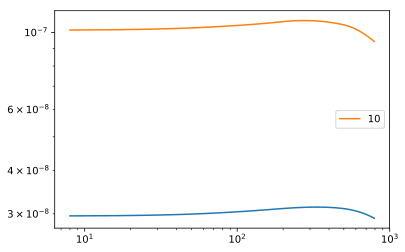

In [132]:
plt.loglog(lres1, clbbres1)
plt.loglog(lres2, clbbres2, label='10')
plt.legend()

In [150]:
llens, clblens = GimmeClBBLens(cmbspec, nwanted=100, n=512, )

/Users/fbianchini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in divide


(2, 1000)

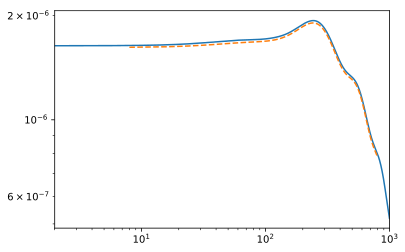

In [151]:
plt.loglog(cmbspec[:1000,2])
plt.loglog(llens, clblens,'--')
plt.xlim(2,1000)

/Users/fbianchini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in divide


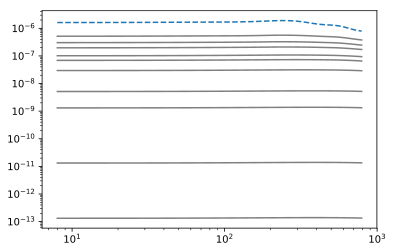

In [136]:
plt.loglog(llens, clblens,'--')
for noise in [0.01,0.1,1,2,5,8,10,15,20,30]:
    plt.loglog(lres1, GimmeClBBRes(cmbspec, 1., noise, nwanted=100)[1], color='grey')


/Users/fbianchini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in divide


(1e-10, 1e-08)

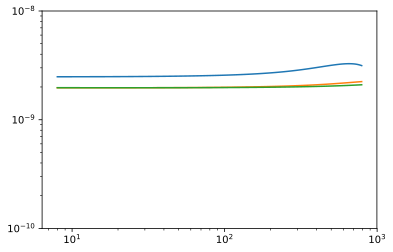

In [143]:
lres, clbres = GimmeClBBRes(cmbspec, 4., 1., nwanted=100, dl=20)
plt.loglog(lres1, clbres)#, color='grey')
lres, clbres = GimmeClBBRes(cmbspec, 4., 1., nwanted=100, dl=8)
plt.loglog(lres1, clbres)#, color='grey')
lres, clbres = GimmeClBBRes(cmbspec, 4., 1., nwanted=100, dl=4, n=1024)
plt.loglog(lres1, clbres)#, color='grey')
plt.ylim(1e-10,1e-8)

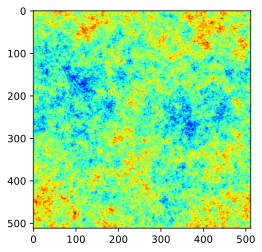

In [162]:
plt.imshow(alpha, cmap='jet')

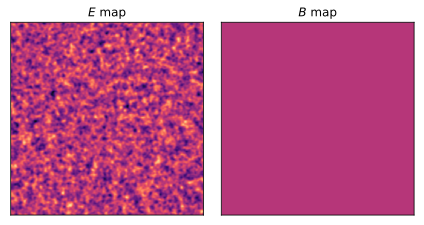

In [29]:
plt.subplot(121)
plt.imshow(Emap, cmap='magma', vmin=-25, vmax=25)
plt.title('$E$ map')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(Bmap, cmap='magma', vmin=-1, vmax=1)
plt.title('$B$ map')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('EB_maps_unrot.pdf')

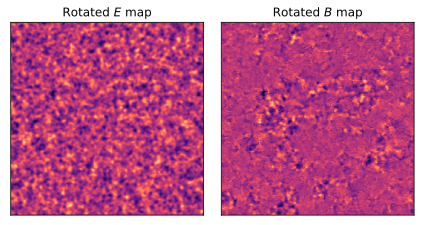

In [33]:
plt.subplot(121)
plt.imshow(EmapRot, cmap='magma', vmin=-25, vmax=25)
plt.title('Rotated $E$ map')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(BmapRot, cmap='magma', vmin=-.5, vmax=.5)
plt.title('Rotated $B$ map')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('EB_maps_rot.pdf')

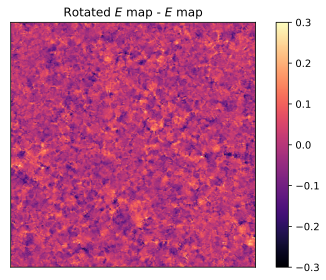

In [43]:
plt.imshow(EmapRot-Emap, cmap='magma', vmin=-0.3, vmax=0.3)
plt.title('Rotated $E$ map - $E$ map')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.colorbar()
plt.savefig('diff_Emap_rot.pdf')


In [56]:
lres1, clbrot = GimmeClBBRot(cmbspec, nwanted=200, A_CB=10, )


/Users/fbianchini/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in divide


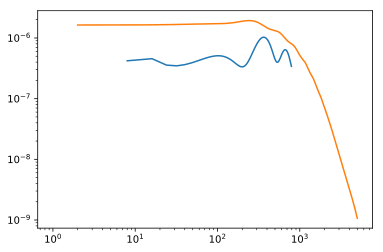

In [55]:
plt.loglog(lres1, clbrot, )
plt.loglog(cmbspec[:,2])